#### Beer Recommender System using Collaborative Filtering (item-item similarity)

The **goal** of this project was to create a recommender system that will take a beer name as an input and return the top N recommendations based on item similiarity. Content based recommendations was explored in a different notebook but the goal was to return recommendations that are varied and not just more of the same (which is what the content-base recommender would do). For example, if I like IPA beers I want to also explore non-IPA beers that may have similar charteristics but are different enough to be categorized as a different class of beer. 
  
The Data:
* 56 subcategories of beer
* 4964 unique beers
* ~88K unique users
* ~1.4M user-review pairings

Data was scraped from a popular beer review website: https://www.beeradvocate.com/
  

Main Tools:   
Surprise Library - http://surpriselib.com/  
scikitleran: https://scikit-learn.org/stable/

NOTE: some of the below functions and code descriptions were taken directly from the Surprise Library Documentation

---

In [203]:
# import libraries

import sys
import pandas as pd
import numpy as np
import re
import csv
import unicodedata
import sys
import time
import pickle
import copy

from collections import defaultdict

from surprise import SVD, evaluate, KNNBasic, NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import KNNBaseline, SVD
from surprise import get_dataset_dir
from surprise.prediction_algorithms import matrix_factorization

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

from scipy import spatial

from tqdm import tqdm
import multiprocessing as multi

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

---
Read in pickled files

Beer and User Review pairings were stored on a MONGODB database hosted on AWS. They were extracted and store across multiple files

In [99]:
files_to_readin = ['5c08e65ebd53771808aecfd0.pkl',
                  '5c08e65ebd53771808aecdf1.pkl',
                  '5c08810bbd5377078577a01c.pkl',
                  '5c08e65dbd53771808aecc12.pkl',
                  '5c08810bbd53770785779e3d.pkl',
                  '5c09a1e2bd53771d03b23e84.pkl',
                  '5c077134bd537720ae8a3a3f.pkl',
                  '5c097527bd53771d03b23ca6.pkl']

t_cols = ['beer_name', 'user', 'rating']
user_rate_combine_df = pd.DataFrame(columns=t_cols)

for i in files_to_readin:
    with open(i, 'rb') as f:
        user_rate_df = pickle.load(f)
        f.close()
    user_rate_combine_df = pd.concat([user_rate_combine_df,user_rate_df])
    

# load in pickled object
with open('user_rate_df.pkl', 'rb') as f:
    user_rate_df = pickle.load(f)
    f.close()
    
with open('all_wheat_user_reviews_df_dict.pkl', 'rb') as f:
    all_wheat_user_reviews_df = pickle.load(f)
    f.close()

In [100]:
# combine everything together
merged_df = pd.concat([user_rate_df, all_wheat_user_reviews_df,user_rate_combine_df])

# change ratings to float
merged_df.rating=merged_df.rating.astype(float)

---

A little bit of cleaning 

In [101]:
def remove_space(s):
    """
    to remove space at end of beer name
    """
    l = list(s)
    l = l[:-1]
    return ''.join(l)

In [102]:
merged_df.beer_name = merged_df.beer_name.apply(lambda x: remove_space(x))

---

#### EDA

In [103]:
merged_df.head()

,beer_name,user,rating
0,Sumatra Mountain Brown (Barrel-Aged),rabbott2,3.50
1,Sumatra Mountain Brown (Barrel-Aged),jhavs,4.04
2,Sumatra Mountain Brown (Barrel-Aged),lupercmda,4.50
3,Sumatra Mountain Brown (Barrel-Aged),Dicers,4.06
4,Sumatra Mountain Brown (Barrel-Aged),RAlmeida77,4.49


In [133]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1427301 entries, 0 to 188328
Data columns (total 3 columns):
beer_name    1427301 non-null object
user         1427301 non-null object
rating       1427301 non-null float64
dtypes: float64(1), object(2)
memory usage: 43.6+ MB


In [118]:
merged_df.describe()

,rating
count,1.427301e+06
mean,4.144708e+00
std,5.686697e-01
min,1.000000e+00
25%,3.890000e+00
50%,4.250000e+00
75%,4.500000e+00
max,5.000000e+00


The average rating for these beers are about 4.14 out of 5. This makes sense since these beers were scraped from "top 100" lists across 56 subcategories.

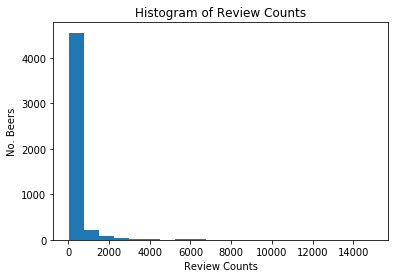

In [119]:
# Histogram of review counts
data= merged_df.beer_name.value_counts()
bins = 20
plt.hist(data,bins=bins,orientation='vertical')
plt.xlabel("Review Counts")
plt.ylabel("No. Beers")
plt.title("Histogram of Review Counts")
plt.show()

In [277]:
merged_df.groupby('beer_name').count().sort_values(by='user', ascending =False).quantile(np.arange(0,1,.05))

About 80% of the beers have less than 200 ratings 

In [278]:
# quantiles of the average ratings
merged_df.groupby('beer_name').mean().sort_values(by='rating', ascending =False).quantile(np.arange(0,1,.05))

In [130]:
avg_rating = merged_df.groupby('beer_name').mean()
subpar = len(avg_rating[avg_rating['rating']<3.5])
print('{} beers have a average rating less than 3.5'.format(subpar))
print('A 3.5 avg rating puts the beer near the bottom 10%-tile')

518 beers have a average rating less than 3.5
A 3.5 avg rating puts the beer near the bottom 10%-tile


In [123]:
# distribution of the bottom 10% in average rating, and number of ratings
bottom_10_rating = merged_df.groupby('beer_name').mean().quantile(np.arange(0,.11,.01))
bottom_10_counts = merged_df.groupby('beer_name').count().quantile(np.arange(0,.11,.01))

In [276]:
bottom_10_rating

In [275]:
bottom_10_counts

The bottom 10%-tile in terms of avg ratings are anywhere from 1.41 to 3.48  
The bottom 10%-tile in terms of number of ratings are anywhere from 9 to 12

---

Now lets take a look at the users

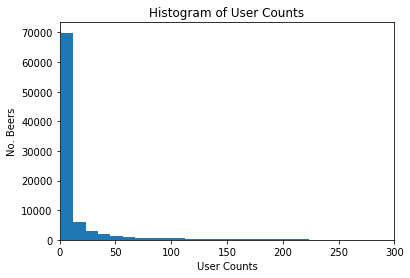

In [167]:
data2= merged_df.user.value_counts()
bins = 100
plt.hist(data2,bins=bins,orientation='vertical')
plt.xlabel("User Counts")
plt.xlim(0,300)
plt.ylabel("No. Beers")
plt.title("Histogram of User Counts")
plt.show()

In [155]:
users = merged_df.groupby('user').count()

In [166]:
counts = [1,2,3,4,5,10,15,20]
for ct in counts:
    num_users = users[users['rating'] <= ct].count()[0]
    print('{} users rated {} or less beers'.format(num_users,ct))

31898 users rated 1 or less beers
44384 users rated 2 or less beers
51242 users rated 3 or less beers
55753 users rated 4 or less beers
59126 users rated 5 or less beers
67935 users rated 10 or less beers
72093 users rated 15 or less beers
74714 users rated 20 or less beers


In [165]:
print('Total number of unique users: {}'.format(len(merged_df.user.unique())))

Total number of unique users: 88600


The vast majority of the users rated only a few beers, with more than half of the users having rated less than 5 beers.

---

To improve results of the recommender, the beers in the bottom 10 percent in terms of avg rating and review counts will be removed. This will remove about 20% of the beers, bringing the unique beers count from 4964 to 3960.

NOTE:
When using the Surprise library, the "shringkage factor" (for imputing missing ratings) takes into account the number of reviews for each item/user. It punishes the items/users with very little reviews. Therefore this step is not critical.

In [257]:
subpar_beers = avg_rating[avg_rating['rating']<3.5]
subpar_beers = list(subpar_beers.index)

In [135]:
rating_ct = merged_df.groupby('beer_name').count()
low_rating = rating_ct[rating_ct['rating']<13]
low_rating = list(low_rating.index)

In [138]:
a = set(subpar_beers)
b = set(low_rating)
c = a.intersection(b)
print('Number of beers in bottom 10% of avg rating: {}'.format(len(a)))
print('Number of beers in bottom 10% of review counts: {}'.format(len(b)))
print('Number of beers in both of these categories: {}'.format(len(c)))

Number of beers in bottom 10% of avg rating: 518
Number of beers in bottom 10% of review counts: 542
Number of beers in both of these categories: 56


In [140]:
#remove beers in the bottom 10% lists
df1 = merged_df[~merged_df.beer_name.isin(subpar_beers)]
df2 = df1[~df1.beer_name.isin(low_rating)]

In [142]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1351390 entries, 0 to 188328
Data columns (total 3 columns):
beer_name    1351390 non-null object
user         1351390 non-null object
rating       1351390 non-null float64
dtypes: float64(1), object(2)
memory usage: 41.2+ MB


In [146]:
print('Original number of unique beers: {}'.format(len(merged_df.beer_name.unique())))
print('Revised number of unique beers: {}'.format(len(df2.beer_name.unique())))

Original number of unique beers: 4964
Revised number of unique beers: 3960


In [147]:
merged_df2 = copy.deepcopy(df2)

### Buidling the model with Surprise

---
**From the Surprise Library Documentation**

What are raw and inner ids?
Users and items have a raw id and an inner id. Some methods will use/return a raw id (e.g. the predict() method), while some other will use/return an inner id.

Raw ids are ids as defined in a rating file or in a pandas dataframe. They can be strings or numbers. Note though that if the ratings were read from a file which is the standard scenario, they are represented as strings. This is important to know if you’re using e.g. predict() or other methods that accept raw ids as parameters.

On trainset creation, each raw id is mapped to a unique integer called inner id, which is a lot more suitable for Surprise to manipulate. Conversions between raw and inner ids can be done using the to_inner_uid(), to_inner_iid(), to_raw_uid(), and to_raw_iid() methods of the trainset.

---

  
  
_The below code creates raw and inner ids for each beer and user_

In [148]:
# create beerID for each beer
_df = merged_df2.groupby('beer_name').count()
dict_ = pd.DataFrame(_df.index)


dict_['beerID']=dict_.index
dict_df=dict_[['beerID','beer_name']]


desc_dict = dict_df.set_index('beer_name').to_dict()
new_dict = desc_dict['beerID']

merged_df2['beerID'] = merged_df2.beer_name.map(new_dict)



# create userID for each user
user_df = merged_df2.groupby('user').count()
dict_user = pd.DataFrame(user_df.index)


dict_user['userID']=dict_user.index
dict_user_df=dict_user[['userID','user']] 


desc_dict_user = dict_user_df.set_index('user').to_dict()
new_dict_user = desc_dict_user['userID']

merged_df2['userID'] = merged_df2.user.map(new_dict_user)

---

_Below code was taken from Surpirse Library Documentation  and modified_

In [149]:
def read_item_names():
    """
    return two mappings to convert raw ids into beer names 
    and beer names into raw ids.
    """

    file_name = dict_df
    rid_to_name = {}
    name_to_rid = {}

    # there are 3960 unique beers after removing the low rating and review count beers
    for i in range(3960):  
        line = file_name.iloc[i]
        rid_to_name[line[0]] = line[1]
        name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid

In [226]:
def get_rec(beer_name, k_):
    """
    Input Beer name and returns k recommendations
    based on item similarity
    
    Input: String, integer
    Output: String
    """
    output = []
    
    beer = str(beer_name)
#     beer = str(beer_name)+' '
    
    # Read the mappings raw id <-> beer name
    rid_to_name, name_to_rid = read_item_names()

    # Retrieve inner id of the Beer
    beer_input_raw_id = name_to_rid[beer]
    beer_input_inner_id = algo.trainset.to_inner_iid(beer_input_raw_id)

    
    K = k_
    
    # Retrieve inner ids of the nearest neighbors of the Beer
    beer_input_neighbors = algo.get_neighbors(beer_input_inner_id, k=K)

    
    # Convert inner ids of the neighbors into names.
    beer_input_neighbors = (algo.trainset.to_raw_iid(inner_id)
                                for inner_id in beer_input_neighbors)
    beer_input_neighbors = (rid_to_name[rid]
                                for rid in beer_input_neighbors)

#     print('The {} nearest neighbors of {} are:'.format(K,beer_name))
    for beer_ in beer_input_neighbors:
        output.append(beer_)
        
    return output

Building the model with Surprise using the KNN Baseline algorithm and Pearson Baseline similarity for item-item comparison. In other words, this recommender system is an item based CF recommender that uses a nearest neighbors appproach as oppose to latent factors (SVD). The Similarity is based on Pearson correlation as oppose to cosine distance or MSD. Please check out the Suprise Library documentation for more information: https://surprise.readthedocs.io/en/stable/

In [152]:
# First, train the algortihm to compute the similarities between items (item-item collaborative filtering)
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(merged_df2[['userID', 'beerID', 'rating']], reader)
trainset = data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [153]:
# Evaluate the performance using Surprise's evaluation module
evaluate(algo, data, measures=['RMSE', 'MAE'])

/anaconda3/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/anaconda3/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm KNNBaseline.

------------
Fold 1
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4033
MAE:  0.2823
------------
Fold 2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4032
MAE:  0.2823
------------
Fold 3
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4047
MAE:  0.2837
------------
Fold 4
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4017
MAE:  0.2824
------------
Fold 5
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4035
MAE:  0.2825
------------
------------
Mean RMSE: 0.4033
Mean MAE : 0.2826
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.4033060264399099,
                             0.4031862159727175,
                             0.40472510543383383,
                             0.4016758268631455,
                             0.4034710227747909],
                            'mae': [0.282263739946719,
                             0.28231484545896524,
                             0.2837116079891318,
                             0.28240986033679993,
                             0.28248927572619553]})

**Note**: the removal of the beers in the bottom 10% of avg rating and review counts improved the RMSE from .41 to .40, in comparison to a previous model using the full list of beers.

---
Lets test out the recommender

In [259]:
# top 20 most rated beers
merged_df2.groupby('beer_name').count().sort_values(by='user', ascending =False)[0:20].index.tolist()

['Two Hearted Ale',
 'Pliny The Elder',
 'Sculpin IPA',
 'Heady Topper',
 'Hopslam Ale',
 'KBS (Kentucky Breakfast Stout)',
 'Bourbon County Brand Stout',
 'Old Rasputin',
 'Enjoy By IPA',
 'Prima Pils',
 'Zombie Dust',
 'Ten FIDY',
 "A Little Sumpin' Sumpin' Ale",
 'Weihenstephaner Hefeweissbier',
 'Jai Alai IPA',
 'Porter',
 'Oberon Ale',
 'Bourbon County Brand Coffee Stout',
 'Victory At Sea - Coffee And Vanilla',
 'The Abyss']

In [260]:
# top 20 highest rating beers
merged_df2.groupby('beer_name').mean().sort_values(by='rating', ascending =False)[0:20].index.tolist()

['Kentucky Brunch Brand Stout',
 'Derivation Blend #9 (Cinnamon/Maple)',
 'Elysium',
 'Monster Tones',
 'It Was All A Dream',
 'Double Tapped',
 'I Let My Tape Rock',
 'Double Shot - Vanilla',
 'Barrel-Aged Abraxas',
 'Oude Fermier',
 'King Julius',
 'Marshmallow Handjee',
 'Popinski - Bourbon Barrel-Aged - Peanut Butter And Marshmallow',
 'King JJJuliusss',
 "Hunahpu's Imperial Stout - Double Barrel Aged",
 'Barrel Aged Imperial German Chocolate Cupcake Stout',
 'Chemtrailmix (2018)',
 'Very Hazy',
 'Heady Topper',
 'SR-71']

In [264]:
print('The 20 nearest neighbors of Kentucky Brunch Brand Stout are:')
get_rec('Kentucky Brunch Brand Stout',20)

The 20 nearest neighbors of Kentucky Brunch Brand Stout are:


["Mornin' Delight",
 'Light Speed',
 'SR-71',
 'Grassroots Convivial Suaréz',
 "Hunahpu's Imperial Stout - Double Barrel Aged",
 'Framboise Du Fermier',
 'Double Dry Hopped Double Mosaic Dream',
 'Dortmunder Gold',
 'Cask Strawberry',
 'Headroom',
 'Moat Water',
 'Sosus',
 'Coffee And Cigarettes',
 'Chocolate Rain',
 'Black Tuesday - Reserve',
 'Bu Weisse',
 'Leffe Blonde',
 'Assassin',
 'Barrel-Aged Silhouette',
 "Saint's Devotion"]

In [265]:
print('The 20 nearest neighbors of Two Hearted Ale are:')
get_rec('Two Hearted Ale',20)

The 20 nearest neighbors of Two Hearted Ale are:


['Hopslam Ale',
 'Malpais Stout',
 'Hacker-Pschorr Munchner Kellerbier (Anno 1417)',
 'Sculpin IPA',
 'Ella',
 'Amber Ale',
 'Sumatra Mountain Brown',
 'Amalgamator',
 'Fade To Black - Volume 1',
 'Citra-Pils Keller Bier',
 'Smokestack Heritage Porter',
 'Hop Program - Beer I',
 'Mocha Marlin',
 '(512) Pecan Porter',
 'Ten FIDY - Rum Barrel-Aged',
 'Pallet Jack IPA',
 'Porter',
 'Metric',
 'Oberon Ale',
 'Christoffel Nobel']

In [182]:
top20rated = merged_df2.groupby('beer_name').count().sort_values(by='user', ascending =False)[0:20].index.tolist()
top20rated = set(top20rated)

top20rating = merged_df2.groupby('beer_name').mean().sort_values(by='rating', ascending =False)[0:20].index.tolist()
top20rating = set(top20rating)

kbbs = set(get_rec('Kentucky Brunch Brand Stout',20))
tha = set(get_rec('Two Hearted Ale',20))

In [189]:
print(kbbs.intersection(top20rated))
print(kbbs.intersection(top20rating))

set()
{'SR-71', "Hunahpu's Imperial Stout - Double Barrel Aged"}


In [190]:
print(tha.intersection(top20rated))
print(tha.intersection(top20rating))

{'Oberon Ale', 'Porter', 'Hopslam Ale', 'Sculpin IPA'}
set()


As you can see above, when I inputed the most rated beer (higest review counts), 'Two Hearted Ale', the recommendations only contained four beers that were in the top 20 most rated list. 

Likewise, when I inputed the highest rating beer (higest average rating), 'Kentucky Brunch Brand Stout', the recommendations only contained 2 beers that were in the top 20 highest ratings list.

This is desirable since the goal of collaborative filtering is to find most similar items based on how users rated them, or vice versa, the recommendations should not be giving more of the same beers (in this case, the highest rated beers or the beers with the highest ratings). For best results, a hybrid system that utilizes content-based filtering along with collaborative filtering would be best.

Testing a couple more:

In [272]:
ebi = set(get_rec('Enjoy By IPA',20))
mbp = set(get_rec('Maple Bacon Coffee Porter',20))

In [273]:
print(ebi.intersection(top20rated))
print(ebi.intersection(top20rating))
print(mbp.intersection(top20rated))
print(mbp.intersection(top20rating))

{'Sculpin IPA'}
set()
set()
set()


In [266]:
print('The 20 nearest neighbors of Enjoy By IPA:')
ebi

The 20 nearest neighbors of Enjoy By IPA:


{'All Green Everything',
 'Black Watch Double Chocolate Milk Stout',
 'Blazing World',
 'Bright',
 'Coriolis',
 'Evil Twin',
 'G-Bot Double IPA',
 'Lunch',
 'Ma',
 'Mosaic IPA',
 'Pallet Jack IPA',
 'Pataskala Red X IPA',
 'Pilz',
 'Project Dank',
 'Sculpin IPA',
 'Stone / Chris Banker / Insurgente - Xocoveza',
 'System Of A Stout',
 'The Pupil',
 'The Rusty Nail',
 "Who You Callin' Wussie"}

In [274]:
print('The 20 nearest neighbors of Maple Bacon Coffee Porter:')
mbp

The 20 nearest neighbors of Maple Bacon Coffee Porter:


{'Bourbon Barrel Aged Dark Star: Coffee Edition',
 'Double Shot',
 'Evil Twin',
 'Flora Blueberry/Black Currant/Raspberry',
 'Framinghammer - Bourbon Barrel-Aged',
 'Fyodor',
 'HOPSMACK!',
 'Last Snow',
 'Lunch',
 'Madagascar',
 'Morning Wood',
 'Naughty 90',
 'Nib Smuggler',
 'Single Shot W/ Vanilla Bean',
 'Society & Solitude #5',
 'Spencer Trappist Ale',
 'Stone / Chris Banker / Insurgente - Xocoveza',
 'Weihenstephaner 1516 Kellerbier',
 "Wide Awake It's Morning",
 'Winter Ale (5th Anniversary Ale)'}

'Enjoy by IPA' is an IPA (Indian Pale Ale) beer. And while the top 20 list for 'Enjoy by IPA' return quite a few other IPAs there were also stouts and an amber ale among others. 

The top 20 list for 'Maple Bacon Coffee Porter' return a more varied list with porters, stouts, IPA and other ales, although most of these beers tend to be on the heavier side with a higher alcohol content and full bodied.

These are desirable results since we want a recommendation engine to give some variety and not just more of the same.

---

### Building a model with sk-learn: latent factors approach

Alternatively, we can use a latent factors approach by using a Truncated SVD. The surprise package also have an algorithm for doing SVD instead of the KNN method, however, it would require some deep dive into the code and making some modification in order to be able to run a truncated SVD. The default SVD module does not allow for a truncated SVD. The reason, why a truncated SVD is needed is because a standard SVD would require too much memory and processing power. Given that we have a matrix of about 5K x 88K, it would not be feasible.


In [198]:
# create pivot table and make it sparse (impute NANs with 0s)
merged_df2_pivot = merged_df2.pivot_table(index='user', columns='beer_name', values='rating').fillna(0)

In [199]:
#pickle
with open('merged_df2_pivot_v2.pkl', 'wb') as f:
    pickle.dump(merged_df2_pivot,f)
    f.close()

# #pickle load
# with open('merged_df2_pivot_v2.pkl', 'rb') as f:
#     merged_df2_pivot =  pickle.load(f)
#     f.close()

In [201]:
merged_df2_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85714 entries, --- to zzurn
Columns: 3960 entries, #Merica to Štěpán - český Klasický Ležák Světlý
dtypes: float64(3960)
memory usage: 2.5+ GB


In [202]:
T = merged_df2_pivot.values.T
T.shape

(3960, 85714)

Using explained variance to determine the number of components for this Truncated SVD

In [214]:
def exp_var(list_):
    '''
    input: list of integers
    output: list of tuples showing n_components and it's explained variance ratio
    '''
    
    out = []
    
    for num in list_:
        SVD = TruncatedSVD(n_components=num,random_state=num)
        SVD.fit_transform(T)
        evar = np.sum(SVD.explained_variance_ratio_)
        t = (num,evar)
        out.append(t)
    
    return out

In [235]:
n_comp = [5,10,20,50,100,200,300]
explained_variance = exp_var(n_comp)

In [234]:
[print(i) for i in explained_variance]

(5, 0.28244698895151277)
(10, 0.3279387126256398)
(20, 0.38133299074926386)
(50, 0.4746472894055872)
(100, 0.5666673880856004)
(200, 0.6743565876599937)
(300, 0.742360634685447)


[None, None, None, None, None, None, None]

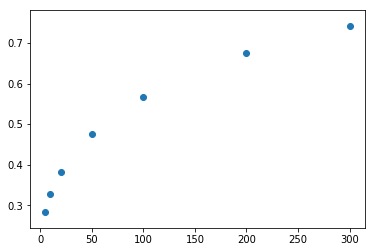

In [216]:
x,y = zip(*explained_variance)
plt.scatter(x, y)

Based on the above information, I decided to use 200 components for this truncated svd. I believe this is fair given that there is only 3900 unique beers over 56 subcategories, and at 200 components the model captures 2/3 of the explained variance.

Each component is a latent feature that a particular beer and user has an affinity to, and given that there is only 3900 beers, you can say that there are 20 (3900 divide by 200) beers per latent factor. 

Another way to think about this is to think about how many differnt ways you can classify or describe the types of beers that are avaiable. Even within the 56 subcategories, many of these subcategories are very similar to one another, most people probably wouldn't be able to tell the difference. However, these latent factors encapsulate features that are hard to explain. For example, a particular latent factor could be charaterized as "slightly hoppy + low alcohol content + light bodied + high carbonation" or a particular subcategory. 

Therefore, if you think about the different criterias of charterizing beers, they may be:
* bitterness/hoppines
* sweetness level
* carbonation level
* nose/aroma 
* body of the beer

Lets say there are 3 levels for each criteria (high,mid,low), then there are 243 combinations (3 to the 5th power) - and that is assuming each criteria is independent of each other which is not the case (hoppy beers tend to have a strong aroma, sweeter beers have a full body). 

---

Create the 200 component Truncated SVD

In [219]:
SVD200 = TruncatedSVD(n_components=200,random_state=200)
matrix200 = SVD200.fit_transform(T)
matrix200.shape

(3960, 200)

In [220]:
# correlation/similarity matrix
corr200 = np.corrcoef(matrix200)
corr200.shape

(3960, 3960)

In [221]:
# #pickle dump
# with open('matrix200.pkl', 'wb') as f:
#     pickle.dump(matrix200,f)
#     f.close()
    
# with open('corr200.pkl', 'wb') as f:
#     pickle.dump(corr200,f)
#     f.close()

# # pickle load
# with open('matrix200.pkl', 'rb') as f:
#     matrix200 = pickle.load(f)
#     f.close()
    
# with open('corr200.pkl', 'rb') as f:
#     corr200 = pickle.load(f)
#     f.close()


In [222]:
# name of all beers
beer_rec_names200 = merged_df2_pivot.columns

# list of all beer names
beer_rec_list200 = list(beer_rec_names200)

In [223]:
def svd200_recs(string,n):
    """
    function returns top n recommendations base on input of beer name and n.
    
    inputs: 
    string (name of beer) -> string
    n (n recommendations) ->  int
    """
    
    # get index of beer name from list of all beers in the training data
    get_index = beer_rec_list200.index(string)
    
    # similarity coeff of all other beers w respect to the input beer
    similarities = corr200[get_index]
    
    # create  & popluate list to hold tuples of beer names and their respective correlation coeff, sorted in reverse
    closest = []    
    for idx, coeff in enumerate(similarities):
        closest.append((beer_rec_list200[idx],coeff))
    
    closest.sort(key=lambda x: x[1], reverse=True)
    
    out = []
#     print('Top {} recommendations are:\n'.format(n))
    for i in range(1,n+1):
#         print(closest[i][0], '\n', closest[i][1])
        out.append(closest[i][0])
    return out

Lets get the top 20 recommendations for the same beers we looked at earlier

In [224]:
svd200_recs('Kentucky Brunch Brand Stout',20)

['Assassin',
 'SR-71',
 "Mornin' Delight",
 'Barrel-Aged Abraxas',
 "Hunahpu's Imperial Stout - Double Barrel Aged",
 'Barrel-Aged Sump Coffee Stout',
 'Saison Du Fermier',
 'Beer Geek Vanilla Shake - Bourbon Barrel-Aged',
 'Framboise Du Fermier',
 'Coffee Abraxas',
 'Beyond Good And Evil',
 'Pugachev Royale',
 'Marshmallow Handjee',
 'Abricot Du Fermier',
 'Barrel-Aged Silhouette',
 'Grande Negro Voodoo Papi - Bourbon Barrel-Aged',
 'DFPF',
 'Maman',
 'Sosus',
 'Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged']

In [229]:
# Latent Factors method
A = set(svd200_recs('Kentucky Brunch Brand Stout',20))

# Neighborhood method
B = set(get_rec('Kentucky Brunch Brand Stout',20))

print('common beers: {}'.format(A.intersection(B)))
print('number of common beers: {}'.format(len(A.intersection(B))))

common beers: {'Framboise Du Fermier', 'SR-71', "Mornin' Delight", "Hunahpu's Imperial Stout - Double Barrel Aged", 'Barrel-Aged Silhouette', 'Sosus', 'Assassin'}
number of common beers: 7


In [230]:
svd200_recs('Two Hearted Ale',20)

['Hopslam Ale',
 'Oberon Ale',
 'Sculpin IPA',
 'Enjoy By IPA',
 'Ten FIDY',
 'Jai Alai IPA',
 'KBS (Kentucky Breakfast Stout)',
 'Old Rasputin',
 'Porter',
 'Alpha King',
 'Bourbon County Brand Stout',
 'Edmund Fitzgerald Porter',
 'Harvest Ale',
 "A Little Sumpin' Sumpin' Ale",
 'Gumballhead',
 'Victory At Sea - Coffee And Vanilla',
 'Dreadnaught IPA',
 'Furious',
 'Zombie Dust',
 'Pliny The Elder']

In [231]:
A = set(svd200_recs('Two Hearted Ale',20))
B = set(get_rec('Two Hearted Ale',20))
print('common beers: {}'.format(A.intersection(B)))
print('number of common beers: {}'.format(len(A.intersection(B))))

common beers: {'Oberon Ale', 'Porter', 'Hopslam Ale', 'Sculpin IPA'}
number of common beers: 4


In [236]:
A = set(svd200_recs('Enjoy By IPA',20))
B = set(get_rec('Enjoy By IPA',20))
print('common beers: {}'.format(A.intersection(B)))
print('number of common beers: {}'.format(len(A.intersection(B))))

common beers: {'Lunch', 'Sculpin IPA'}
number of common beers: 2


In [237]:
A = set(svd200_recs('Elysium',20))
B = set(get_rec('Elysium',20))
print('common beers: {}'.format(A.intersection(B)))
print('number of common beers: {}'.format(len(A.intersection(B))))

common beers: {'Moe Beer', 'Acerbic Ecstasy'}
number of common beers: 2


#### Comparing the two different Method: LF vs KNN

In [255]:
def compare_recs(name_list,n):

    '''
    inputs: 
    name_list(list of beer names) -> list
    n (number of recommendations) -> integer
    
    output: 
    graph showing the number of common beers between two different CF methods for each of the input beer
    
    '''
    results = []
    
    for idx, name in enumerate(name_list):
        svd = set(svd200_recs(name,n))
        knn = set(get_rec(name,n))
        common = len(svd.intersection(knn))
        tup = (idx, common)
        results.append(tup)
    
    x,y = zip(*results)
    plt.scatter(x, y)
    plt.xlabel('Beer No.')
    plt.ylabel('Common Recs')
    plt.show()

In [251]:
# select every 40 beers from highest avg rating to lowest avg rating
namelist = merged_df2.groupby('beer_name').mean().sort_values(by='rating', ascending =False)[::40].index.tolist()

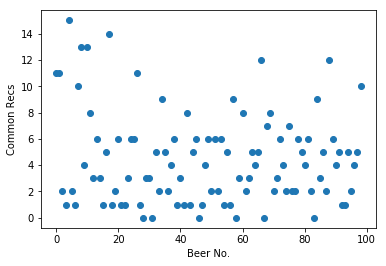

In [256]:
compare_recs(namelist,50)

The above graph shows the number of common closest beers or top recommendations from both the SVD and the nearest neighbors models for a sample of 99 beers (ranging from highest ratings to lowest ratings). As you can see, out of the top 50 closest beers, the amount of overlap between the two methods ranges from 0 to 15 which translates to 0-30%. So the two different methods returns very different results and this is expected because a SVD captures relationships that the a nearest neighbor approach does not.  

---

**Conclusion:**

Building a collaborative filtering recommender system can be quite simple. The Surprise Library is a great module to use. You can use a neighbors appraoch (KNN) or a latent factors approach (SVD). Both methods may yield very differnt results, however, this may actually be a good thing as you can combine both results to create a hybrid recommeder system. Collaborative filtering is great if you want your recommendation engine to provide diverse or varied results. Otherwise you can just use a content-based recommender, which in this case would recommend mostly beers within the same subcategory. Combining results from two or all three (content-based, KNN, SVD) would probably be your best bet.    